In [308]:
import json

import pandas as pd
import pantab
import plotly.graph_objects as go
from IPython.core.interactiveshell import InteractiveShell
from plotly.subplots import make_subplots
from pymongo import MongoClient

InteractiveShell.ast_node_interactivity = "all"

In [269]:
client = MongoClient("localhost:27017")
db = client["wallstreetbets"]
submission_records = db.submission_records
df = pd.DataFrame(list(submission_records.find({})))
df.columns
df.shape

Index(['_id', 'id', 'author', 'author_deleted', 'body_emoji', 'created_utc',
       'distinguished', 'edited_utc', 'is_edited', 'is_locked', 'is_nsfw',
       'is_original_content', 'is_removed_by_author',
       'is_removed_by_moderator', 'is_self_post', 'is_stickied',
       'link_flair_text', 'num_comments', 'permalink', 'score', 'selftext',
       'title', 'title_emoji', 'upvote_ratio', 'url', 'toxicity',
       'roberta-sentiment', 'hate-speech', 'toxicity_ensemble', 'mbti'],
      dtype='object')

(52126, 30)

In [270]:
df.head(1).loc[:, 'id':'link_flair_text']
df.head(1).loc[:, 'num_comments':'url']
df.head(1).loc[:, 'toxicity':'mbti']

,id,author,author_deleted,body_emoji,created_utc,distinguished,edited_utc,is_edited,is_locked,is_nsfw,is_original_content,is_removed_by_author,is_removed_by_moderator,is_self_post,is_stickied,link_flair_text
0,l6ulcx,leecharles_,False,[],1.611834e+09,None,,False,False,False,False,False,False,False,False,Meme


,num_comments,permalink,score,selftext,title,title_emoji,upvote_ratio,url
0,1115,https://redd.it/l6ulcx,60106,,"It's not about the money, it's about sending a...","[:gem_stone:, :rocket:, :raising_hands:]",0.97,https://v.redd.it/6j75regs72e61


,toxicity,roberta-sentiment,hate-speech,toxicity_ensemble,mbti
0,"{'title': {'identity_hate': False, 'insult': F...","{'title': {'emotion': {'class': 'joy', 'joy': ...","{'title': {'class': 'normal', 'score': 0.82891...","{'title': {'identity_hate': False, 'insult': F...",NaN


In [271]:
toxicity_ensemble = pd.json_normalize(df["toxicity_ensemble"]).add_prefix(
    "toxicity_ensemble_"
)
toxicity = pd.json_normalize(df["toxicity"]).add_prefix("toxicity_")
sentiment = pd.json_normalize(df["roberta-sentiment"]).add_prefix("sentiment_")
hate = pd.json_normalize(df["hate-speech"]).add_prefix("hate_")
mbti = pd.json_normalize(df["mbti"]).add_prefix("mbti_")
df_flat = pd.concat(
    [
        df.drop(
            [
                "toxicity",
                "toxicity_ensemble",
                "roberta-sentiment",
                "hate-speech",
                "mbti",
            ],
            axis=1,
        ),
        toxicity,
        toxicity_ensemble,
        sentiment,
        hate,
        mbti,
    ],
    axis=1,
)
df_flat.columns
df_flat.shape

Index(['_id', 'id', 'author', 'author_deleted', 'body_emoji', 'created_utc',
       'distinguished', 'edited_utc', 'is_edited', 'is_locked', 'is_nsfw',
       'is_original_content', 'is_removed_by_author',
       'is_removed_by_moderator', 'is_self_post', 'is_stickied',
       'link_flair_text', 'num_comments', 'permalink', 'score', 'selftext',
       'title', 'title_emoji', 'upvote_ratio', 'url',
       'toxicity_title.identity_hate', 'toxicity_title.insult',
       'toxicity_title.obscene', 'toxicity_title.severe_toxic',
       'toxicity_title.threat', 'toxicity_title.toxic',
       'toxicity_text.identity_hate', 'toxicity_text.insult',
       'toxicity_text.obscene', 'toxicity_text.severe_toxic',
       'toxicity_text.threat', 'toxicity_text.toxic',
       'toxicity_ensemble_title.identity_hate',
       'toxicity_ensemble_title.insult', 'toxicity_ensemble_title.obscene',
       'toxicity_ensemble_title.severe_toxic',
       'toxicity_ensemble_title.threat', 'toxicity_ensemble_title.

(52126, 79)

In [272]:
for col in [
    "author_deleted",
    "distinguished",
    "is_edited",
    "is_locked",
    "is_nsfw",
    "is_original_content",
    "is_removed_by_author",
    "is_removed_by_moderator",
    "is_self_post",
    "is_stickied",
    "link_flair_text",
]:
    print("\033[1m" + col + "\033[0m: ")
    print(df_flat[col].unique())
    print(
        (df_flat[col].value_counts(normalize=True, dropna=False) * 100.0).to_string(
            dtype=False
        ),
        "\n",
    )

author_deleted: 
[False  True]
False    81.573495
True     18.426505 

distinguished: 
[None 'moderator']
NaN          99.894486
moderator     0.105514 

is_edited: 
[False  True]
False    87.856348
True     12.143652 

is_locked: 
[False  True]
False    99.936692
True      0.063308 

is_nsfw: 
[False  True]
False    99.758278
True      0.241722 

is_original_content: 
[False  True]
False    96.940107
True      3.059893 

is_removed_by_author: 
[False  True]
False    84.313011
True     15.686989 

is_removed_by_moderator: 
[False  True]
False    90.029927
True      9.970073 

is_self_post: 
[False  True]
True     52.300196
False    47.699804 

is_stickied: 
[False]
False    100.0 

link_flair_text: 
['Meme' 'Discussion' 'News' 'Chart' 'Gain' 'DD' 'YOLO' 'Daily Discussion'
 'Loss' None 'Mods' 'Shitpost' 'Weekend Discussion' 'Earnings Thread'
 'Donation' 'Tendies' "Tuesday 2-Feb. I'm retarded"
 'Literally 10 minutes long' 'Official' 'meme'
 'Shitpost masquerading as DD' 'Science!' 'GME T

In [273]:
for (col, data) in df_flat.filter(regex="^toxicity_", axis=1).iteritems():
    print("\033[1m" + col + "\033[0m: ")
    print(
        (data.value_counts(normalize=True, dropna=False) * 100.0).to_string(
            dtype=False
        ),
        "\n",
    )

toxicity_title.identity_hate: 
False    99.96355
NaN       0.03645 

toxicity_title.insult: 
False    97.671028
True      2.292522
NaN       0.036450 

toxicity_title.obscene: 
False    97.532901
True      2.430649
NaN       0.036450 

toxicity_title.severe_toxic: 
False    99.944366
NaN       0.036450
True      0.019184 

toxicity_title.threat: 
False    99.96355
NaN       0.03645 

toxicity_title.toxic: 
False    95.863868
True      4.099682
NaN       0.036450 

toxicity_text.identity_hate: 
NaN      68.439934
False    31.554311
True      0.005755 

toxicity_text.insult: 
NaN      68.439934
False    30.349538
True      1.210528 

toxicity_text.obscene: 
NaN      68.439934
False    30.458888
True      1.101178 

toxicity_text.severe_toxic: 
NaN      68.439934
False    31.548555
True      0.011511 

toxicity_text.threat: 
NaN      68.439934
False    31.560066 

toxicity_text.toxic: 
NaN      68.439934
False    17.423167
True     14.136899 

toxicity_ensemble_title.identity_hate: 
False

In [274]:
for (col, data) in df_flat.filter(regex="^sentiment_", axis=1).iteritems():
    if "class" in col:
        print("\033[1m" + col + "\033[0m: ")
        print(
            (data.value_counts(normalize=True, dropna=False) * 100.0).to_string(
                dtype=False
            ),
            "\n",
        )

sentiment_title.emotion.class: 
joy         36.933584
anger       30.117408
sadness     20.298891
optimism    12.619422
NaN          0.030695 

sentiment_title.sentiment.class: 
neutral     72.171277
negative    17.977593
positive     9.820435
NaN          0.030695 

sentiment_text.emotion.class: 
NaN         68.432260
joy         11.218969
anger       10.501477
sadness      7.138472
optimism     2.708821 

sentiment_text.sentiment.class: 
NaN         68.432260
neutral     19.481641
negative     8.155239
positive     3.930860 



In [275]:
for (col, data) in df_flat.filter(regex="^hate_", axis=1).iteritems():
    if "class" in col:
        print("\033[1m" + col + "\033[0m: ")
        print(
            (data.value_counts(normalize=True, dropna=False) * 100.0).to_string(
                dtype=False
            ),
            "\n",
        )

hate_title.class: 
normal         96.544910
offensive       3.307371
hate speech     0.117024
NaN             0.030695 

hate_text.class: 
NaN            68.432260
normal         28.538541
offensive       2.929440
hate speech     0.099758 



In [276]:
for (col, data) in df_flat.filter(regex="^mbti_", axis=1).iteritems():
    print("\033[1m" + col + "\033[0m: ")
    print(
        (data.value_counts(normalize=True, dropna=False) * 100.0).to_string(
            dtype=False
        ),
        "\n",
    )

mbti_energy: 
NaN             68.432260
introversion    27.492998
extraversion     4.074742 

mbti_information: 
NaN          68.432260
intuition    31.448797
sensing       0.118943 

mbti_decisions: 
NaN         68.43226
feeling     18.45720
thinking    13.11054 

mbti_lifestyle: 
NaN           68.432260
perceiving    28.191306
judging        3.376434 

mbti_type: 
NaN     68.432260
INFP    14.718183
INTP     9.714922
ENFP     2.244561
INTJ     1.720830
ENTP     1.421555
INFJ     1.250815
ENTJ     0.193761
ENFJ     0.184169
ISFP     0.036450
ISTP     0.034532
ESFP     0.013429
ISFJ     0.009592
ESTJ     0.009592
ISTJ     0.007674
ESTP     0.007674 



In [277]:
df_out = df_flat.drop(["_id", "body_emoji", "title_emoji"], axis=1)
df_out["edited_utc"] = df_out["edited_utc"].astype(str)
df_out["created_utc"] = pd.to_datetime(df_out["created_utc"], unit="s")


for (col, data) in df_out.filter(regex="^toxicity_", axis=1).iteritems():
    df_out[col] = df_out[col].astype(str)
for (col, data) in df_out.filter(regex="^sentiment_", axis=1).iteritems():
    df_out[col] = df_out[col].astype(str)
for (col, data) in df_out.filter(regex="^hate_", axis=1).iteritems():
    df_out[col] = df_out[col].astype(str)

pantab.frame_to_hyper(df_out, "wsb.hyper", table="wsb")

## Toxic vs Emotions

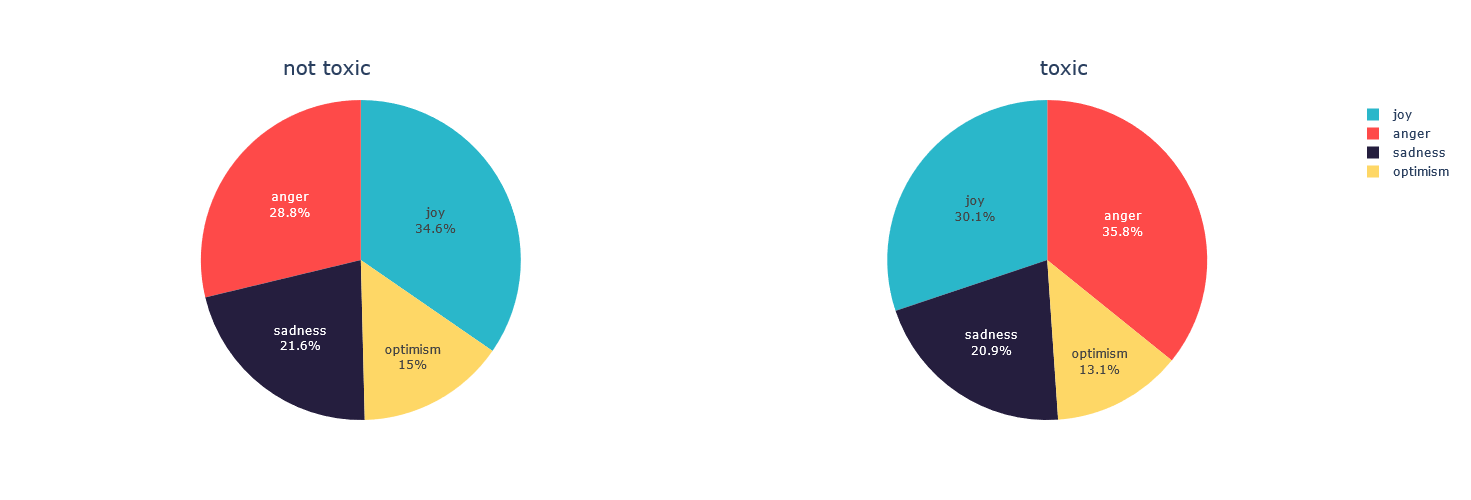

In [363]:
colors = ["#fe4a49", "#2ab7ca", "#fed766", "#251e3e"]

col1 = (
    df_flat.loc[df_flat["toxicity_ensemble_text.toxic"] == False][
        "sentiment_title.emotion.class"
    ]
    .value_counts()
    .sort_index()
)
labels1 = col1.index.tolist()
values1 = col1.values.tolist()
col2 = (
    df_flat.loc[df_flat["toxicity_ensemble_text.toxic"] == True][
        "sentiment_title.emotion.class"
    ]
    .value_counts()
    .sort_index()
)
labels2 = col2.index.tolist()
values2 = col2.values.tolist()


fig = make_subplots(rows=1, cols=2, specs=[[{"type": "domain"}, {"type": "domain"}]])
_ = fig.add_trace(
    go.Pie(
        labels=labels1,
        values=values1,
        name="non-toxic",
        textinfo="label+percent",
        marker_colors=colors,
    ),
    1,
    1,
)
_ = fig.add_trace(
    go.Pie(
        labels=labels2,
        values=values2,
        name="toxic",
        textinfo="label+percent",
        marker_colors=colors,
    ),
    1,
    2,
)

_ = fig.update_layout(
    annotations=[
        dict(text="not toxic", x=0.16, y=1.15, font_size=20, showarrow=False),
        dict(text="toxic", x=0.81, y=1.15, font_size=20, showarrow=False),
    ],
    width=1000,
    height=500,
)
fig.show()

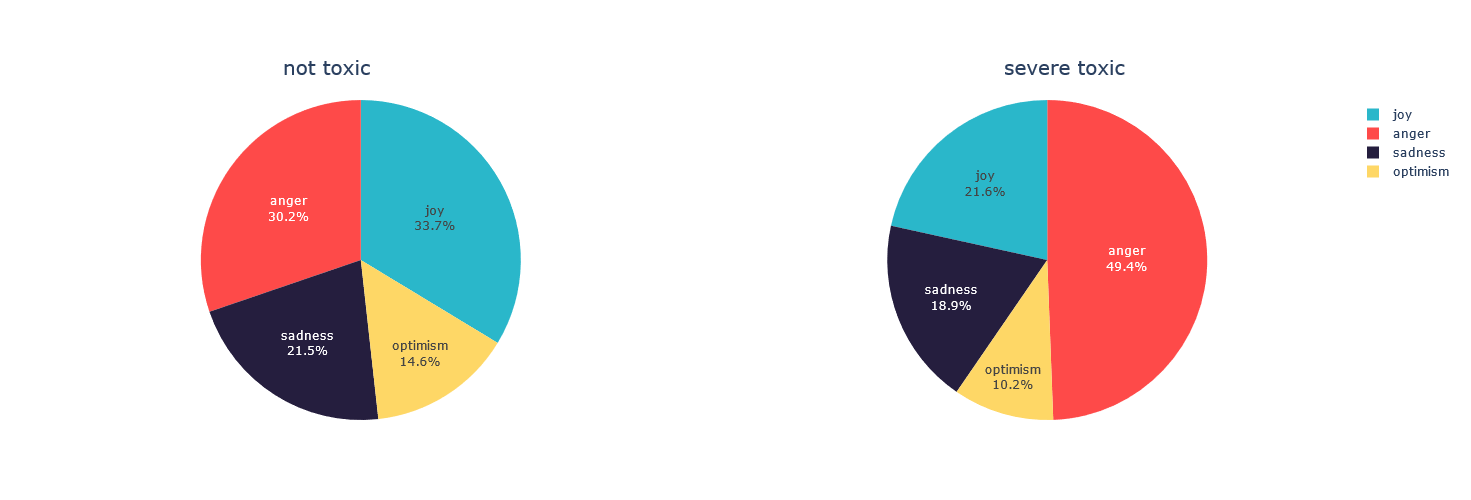

In [364]:
colors = ["#fe4a49", "#2ab7ca", "#fed766", "#251e3e"]

col1 = (
    df_flat.loc[df_flat["toxicity_ensemble_text.severe_toxic"] == False][
        "sentiment_title.emotion.class"
    ]
    .value_counts()
    .sort_index()
)
labels1 = col1.index.tolist()
values1 = col1.values.tolist()
col2 = (
    df_flat.loc[df_flat["toxicity_ensemble_text.severe_toxic"] == True][
        "sentiment_title.emotion.class"
    ]
    .value_counts()
    .sort_index()
)
labels2 = col2.index.tolist()
values2 = col2.values.tolist()


fig = make_subplots(rows=1, cols=2, specs=[[{"type": "domain"}, {"type": "domain"}]])
_ = fig.add_trace(
    go.Pie(
        labels=labels1,
        values=values1,
        name="non-toxic",
        textinfo="label+percent",
        marker_colors=colors,
    ),
    1,
    1,
)
_ = fig.add_trace(
    go.Pie(
        labels=labels2,
        values=values2,
        name="severe toxic",
        textinfo="label+percent",
        marker_colors=colors,
    ),
    1,
    2,
)

_ = fig.update_layout(
    annotations=[
        dict(text="not toxic", x=0.16, y=1.15, font_size=20, showarrow=False),
        dict(text="severe toxic", x=0.84, y=1.15, font_size=20, showarrow=False),
    ],
    width=1000,
    height=500,
)
fig.show()

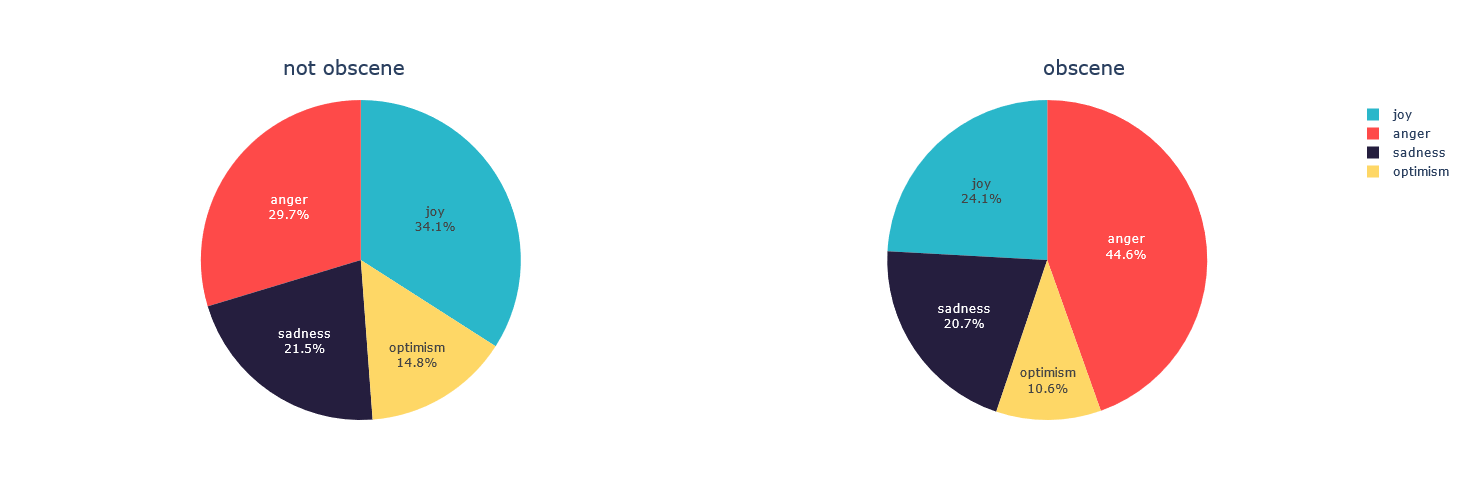

In [362]:
colors = ["#fe4a49", "#2ab7ca", "#fed766", "#251e3e"]

col1 = (
    df_flat.loc[df_flat["toxicity_ensemble_text.obscene"] == False][
        "sentiment_title.emotion.class"
    ]
    .value_counts()
    .sort_index()
)
labels1 = col1.index.tolist()
values1 = col1.values.tolist()
col2 = (
    df_flat.loc[df_flat["toxicity_ensemble_text.obscene"] == True][
        "sentiment_title.emotion.class"
    ]
    .value_counts()
    .sort_index()
)
labels2 = col2.index.tolist()
values2 = col2.values.tolist()


fig = make_subplots(rows=1, cols=2, specs=[[{"type": "domain"}, {"type": "domain"}]])
_ = fig.add_trace(
    go.Pie(
        labels=labels1,
        values=values1,
        name="not obscene",
        textinfo="label+percent",
        marker_colors=colors,
    ),
    1,
    1,
)
_ = fig.add_trace(
    go.Pie(
        labels=labels2,
        values=values2,
        name="obscene",
        textinfo="label+percent",
        marker_colors=colors,
    ),
    1,
    2,
)

_ = fig.update_layout(
    annotations=[
        dict(text="not obscene", x=0.16, y=1.15, font_size=20, showarrow=False),
        dict(text="obscene", x=0.84, y=1.15, font_size=20, showarrow=False),
    ],
    width=1000,
    height=500,
)
fig.show()

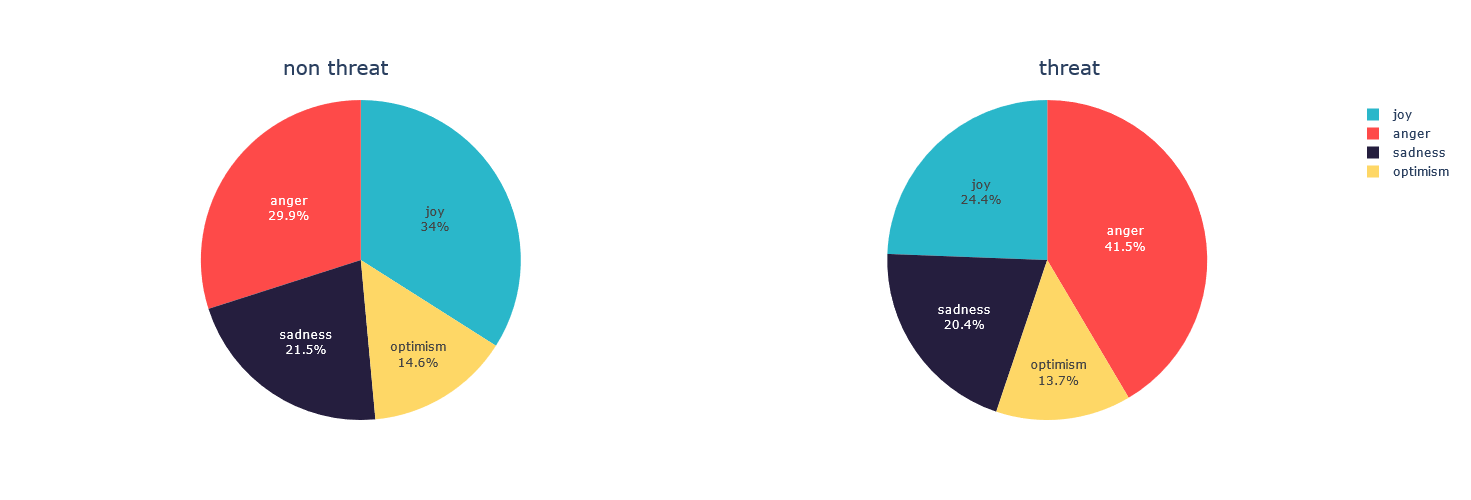

In [366]:
colors = ["#fe4a49", "#2ab7ca", "#fed766", "#251e3e"]

col1 = (
    df_flat.loc[df_flat["toxicity_ensemble_text.threat"] == False][
        "sentiment_title.emotion.class"
    ]
    .value_counts()
    .sort_index()
)
labels1 = col1.index.tolist()
values1 = col1.values.tolist()
col2 = (
    df_flat.loc[df_flat["toxicity_ensemble_text.threat"] == True][
        "sentiment_title.emotion.class"
    ]
    .value_counts()
    .sort_index()
)
labels2 = col2.index.tolist()
values2 = col2.values.tolist()


fig = make_subplots(rows=1, cols=2, specs=[[{"type": "domain"}, {"type": "domain"}]])
_ = fig.add_trace(
    go.Pie(
        labels=labels1,
        values=values1,
        name="non threat",
        textinfo="label+percent",
        marker_colors=colors,
    ),
    1,
    1,
)
_ = fig.add_trace(
    go.Pie(
        labels=labels2,
        values=values2,
        name="threat",
        textinfo="label+percent",
        marker_colors=colors,
    ),
    1,
    2,
)

_ = fig.update_layout(
    annotations=[
        dict(text="non threat", x=0.16, y=1.15, font_size=20, showarrow=False),
        dict(text="threat", x=0.82, y=1.15, font_size=20, showarrow=False),
    ],
    width=1000,
    height=500,
)
fig.show()

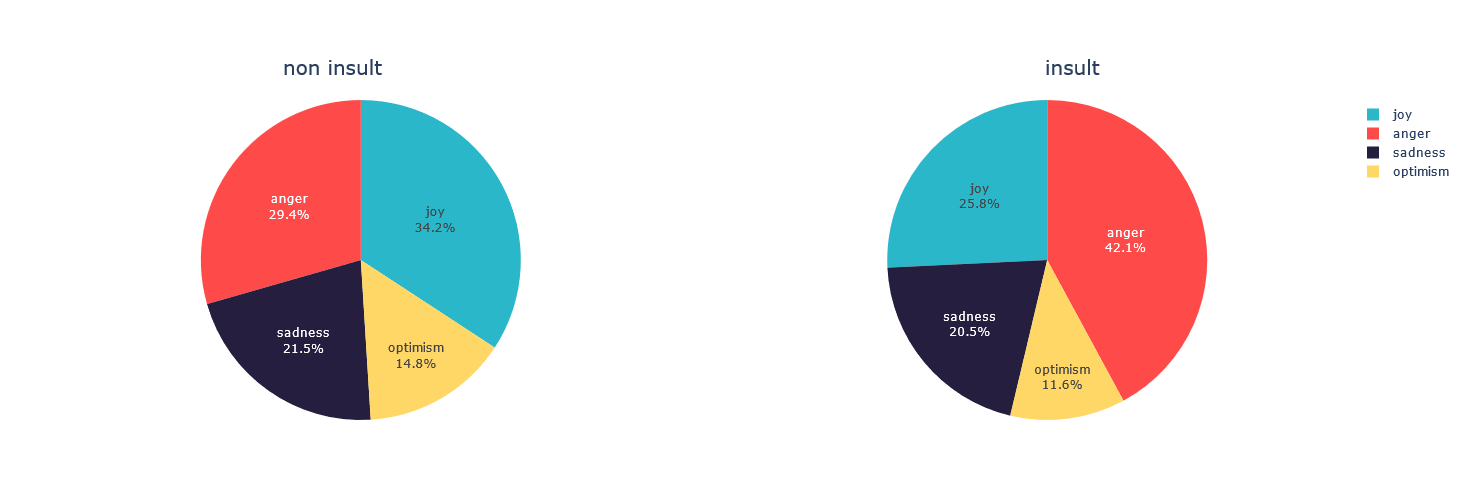

In [367]:
colors = ["#fe4a49", "#2ab7ca", "#fed766", "#251e3e"]

col1 = (
    df_flat.loc[df_flat["toxicity_ensemble_text.insult"] == False][
        "sentiment_title.emotion.class"
    ]
    .value_counts()
    .sort_index()
)
labels1 = col1.index.tolist()
values1 = col1.values.tolist()
col2 = (
    df_flat.loc[df_flat["toxicity_ensemble_text.insult"] == True][
        "sentiment_title.emotion.class"
    ]
    .value_counts()
    .sort_index()
)
labels2 = col2.index.tolist()
values2 = col2.values.tolist()


fig = make_subplots(rows=1, cols=2, specs=[[{"type": "domain"}, {"type": "domain"}]])
_ = fig.add_trace(
    go.Pie(
        labels=labels1,
        values=values1,
        name="non insult",
        textinfo="label+percent",
        marker_colors=colors,
    ),
    1,
    1,
)
_ = fig.add_trace(
    go.Pie(
        labels=labels2,
        values=values2,
        name="insult",
        textinfo="label+percent",
        marker_colors=colors,
    ),
    1,
    2,
)

_ = fig.update_layout(
    annotations=[
        dict(text="non insult", x=0.16, y=1.15, font_size=20, showarrow=False),
        dict(text="insult", x=0.82, y=1.15, font_size=20, showarrow=False),
    ],
    width=1000,
    height=500,
)
fig.show()

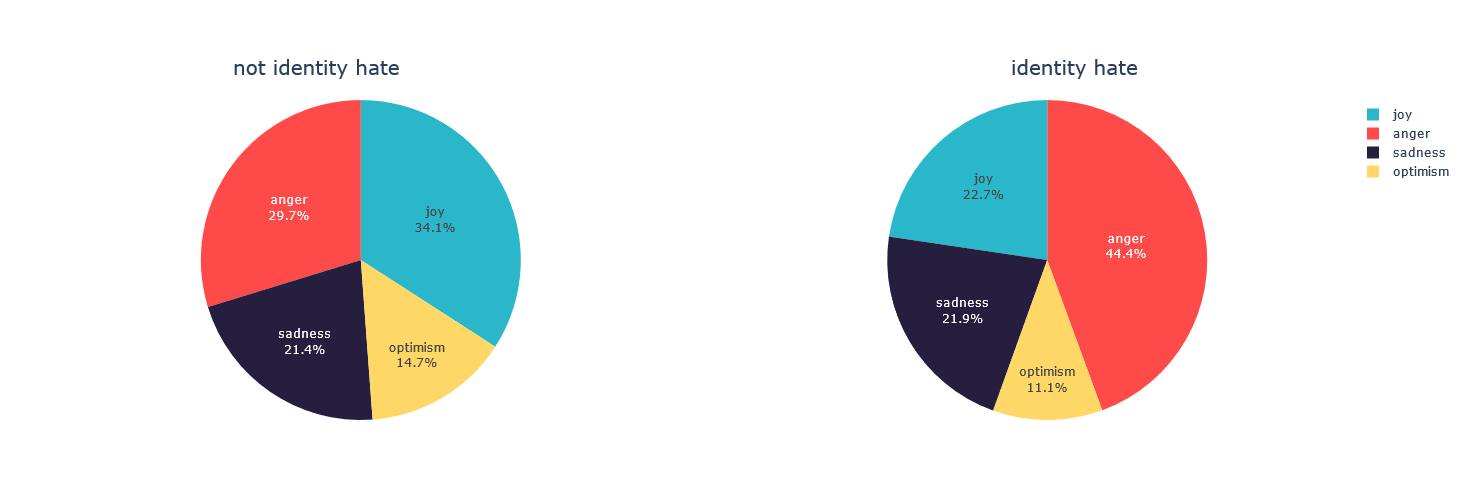

In [386]:
colors = ["#fe4a49", "#2ab7ca", "#fed766", "#251e3e"]

col1 = (
    df_flat.loc[df_flat["toxicity_ensemble_text.identity_hate"] == False][
        "sentiment_title.emotion.class"
    ]
    .value_counts()
    .sort_index()
)
labels1 = col1.index.tolist()
values1 = col1.values.tolist()
col2 = (
    df_flat.loc[df_flat["toxicity_ensemble_text.identity_hate"] == True][
        "sentiment_title.emotion.class"
    ]
    .value_counts()
    .sort_index()
)
labels2 = col2.index.tolist()
values2 = col2.values.tolist()


fig = make_subplots(rows=1, cols=2, specs=[[{"type": "domain"}, {"type": "domain"}]])
_ = fig.add_trace(
    go.Pie(
        labels=labels1,
        values=values1,
        name="not identity hate",
        textinfo="label+percent",
        marker_colors=colors,
    ),
    1,
    1,
)
_ = fig.add_trace(
    go.Pie(
        labels=labels2,
        values=values2,
        name="identity_hate",
        textinfo="label+percent",
        marker_colors=colors,
    ),
    1,
    2,
)

_ = fig.update_layout(
    annotations=[
        dict(text="not identity hate", x=0.12, y=1.15, font_size=20, showarrow=False),
        dict(text="identity hate", x=0.85, y=1.15, font_size=20, showarrow=False),
    ],
    width=1000,
    height=500,
)
fig.show()

## Toxic vs Sentiment

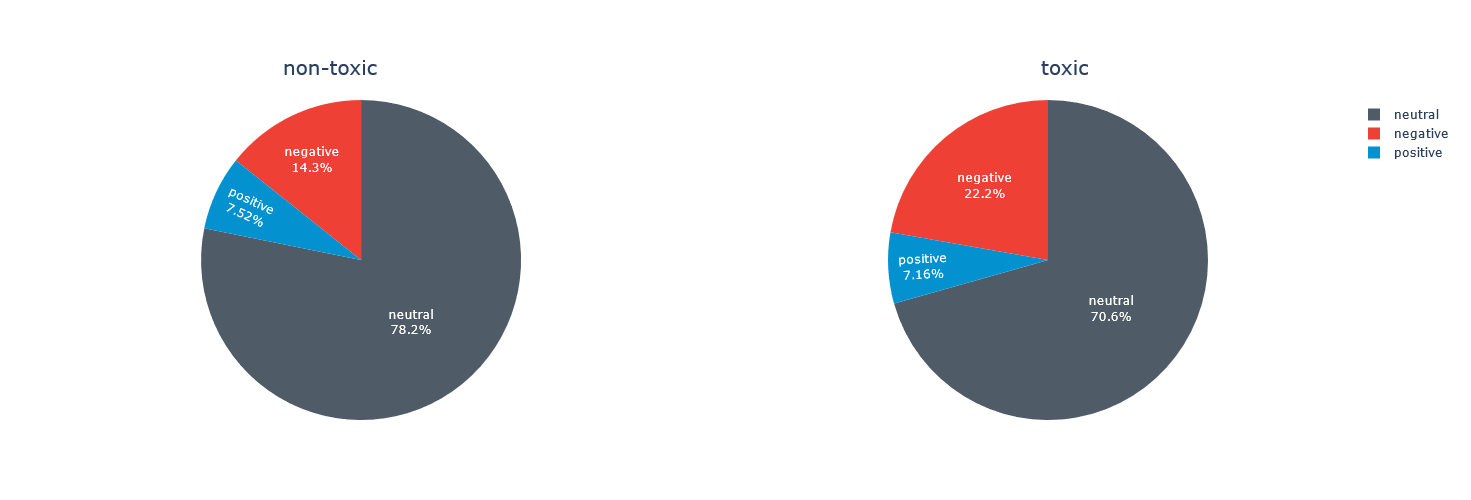

In [387]:
colors = ["#ee4035", "#4f5b66", "#0392cf"]

col1 = (
    df_flat.loc[df_flat["toxicity_ensemble_text.toxic"] == False][
        "sentiment_title.sentiment.class"
    ]
    .value_counts()
    .sort_index()
)
labels1 = col1.index.tolist()
values1 = col1.values.tolist()
col2 = (
    df_flat.loc[df_flat["toxicity_ensemble_text.toxic"] == True][
        "sentiment_title.sentiment.class"
    ]
    .value_counts()
    .sort_index()
)
labels2 = col2.index.tolist()
values2 = col2.values.tolist()


# Create subplots: use 'domain' type for Pie subplot
fig = make_subplots(rows=1, cols=2, specs=[[{"type": "domain"}, {"type": "domain"}]])
_ = fig.add_trace(
    go.Pie(labels=labels1, values=values1, name="non-toxic", textinfo="label+percent", marker_colors=colors),
    1,
    1,
)
_ = fig.add_trace(
    go.Pie(labels=labels2, values=values2, name="toxic", textinfo="label+percent", marker_colors=colors), 1, 2
)

_ = fig.update_layout(
    annotations=[
        dict(text="non-toxic", x=0.16, y=1.15, font_size=20, showarrow=False),
        dict(text="toxic", x=0.81, y=1.15, font_size=20, showarrow=False),
    ],
    width=1000,
    height=500,
)
fig.show()

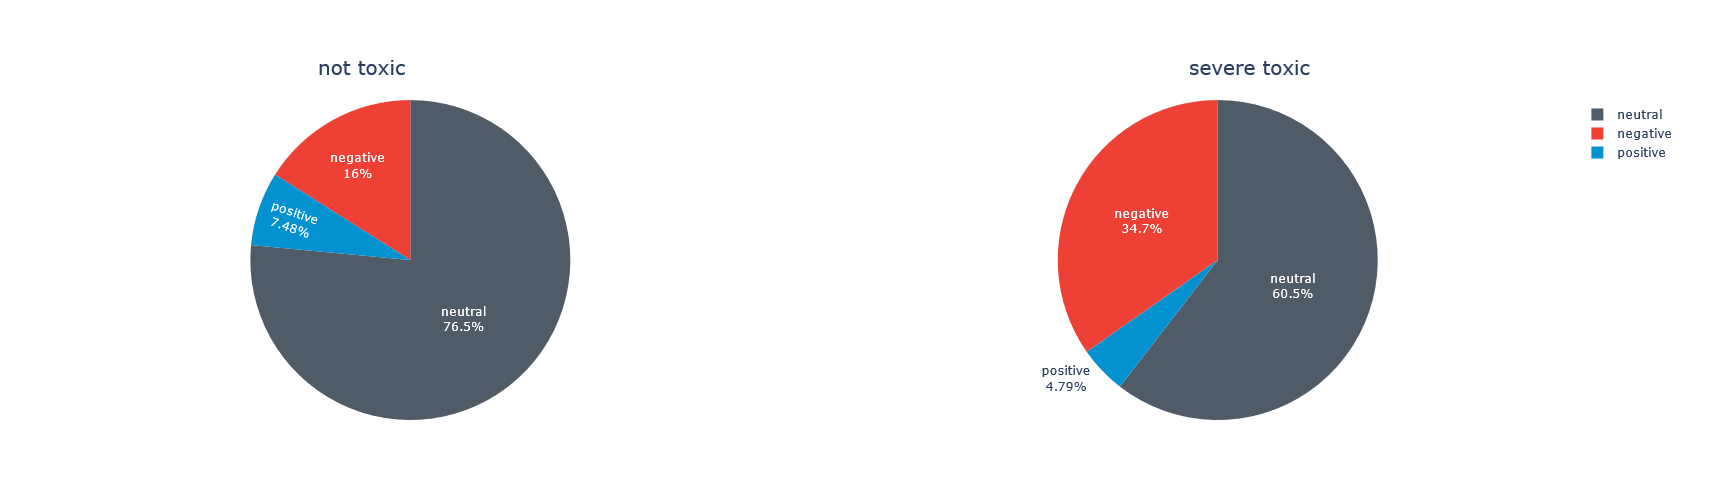

In [412]:
colors = ["#ee4035", "#4f5b66", "#0392cf"]

col1 = (
    df_flat.loc[df_flat["toxicity_ensemble_text.severe_toxic"] == False][
        "sentiment_title.sentiment.class"
    ]
    .value_counts()
    .sort_index()
)
labels1 = col1.index.tolist()
values1 = col1.values.tolist()
col2 = (
    df_flat.loc[df_flat["toxicity_ensemble_text.severe_toxic"] == True][
        "sentiment_title.sentiment.class"
    ]
    .value_counts()
    .sort_index()
)
labels2 = col2.index.tolist()
values2 = col2.values.tolist()


fig = make_subplots(rows=1, cols=2, specs=[[{"type": "domain"}, {"type": "domain"}]])
_ = fig.add_trace(
    go.Pie(
        labels=labels1,
        values=values1,
        name="non-toxic",
        textinfo="label+percent",
        marker_colors=colors,
    ),
    1,
    1,
)
_ = fig.add_trace(
    go.Pie(
        labels=labels1,
        values=values2,
        name="severe toxic",
        textinfo="label+percent",
        marker_colors=colors,
    ),
    1,
    2,
)

_ = fig.update_layout(
    annotations=[
        dict(text="not toxic", x=0.16, y=1.15, font_size=20, showarrow=False),
        dict(text="severe toxic", x=0.84, y=1.15, font_size=20, showarrow=False),
    ],
    width=1000,
    height=500,
)
fig.show()

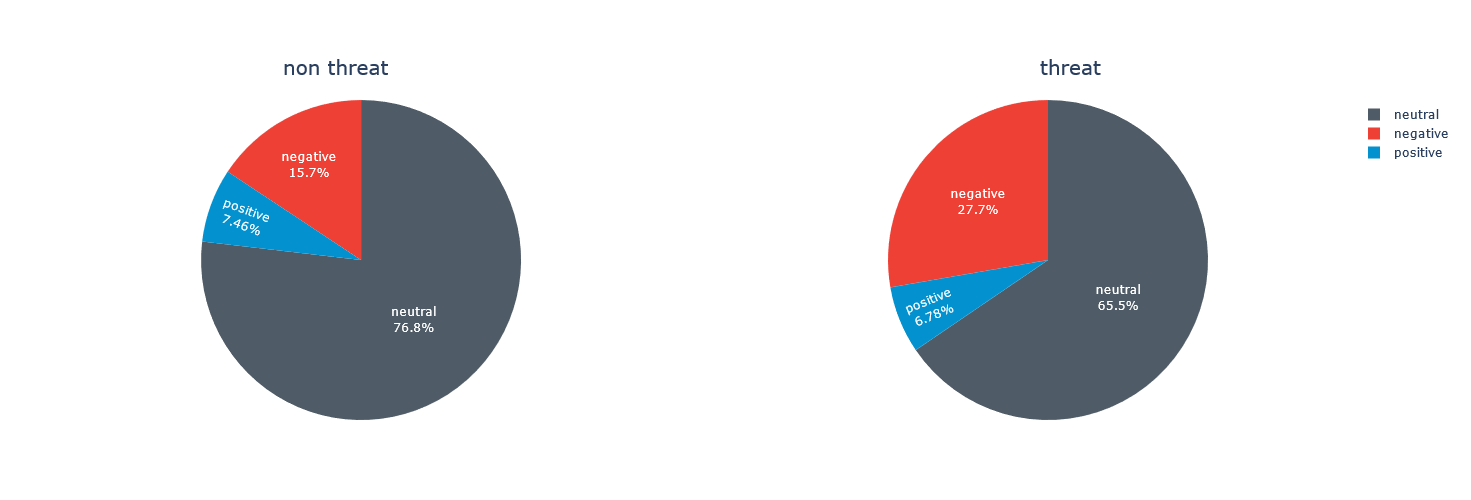

In [390]:
colors = ["#ee4035", "#4f5b66", "#0392cf"]

col1 = (
    df_flat.loc[df_flat["toxicity_ensemble_text.threat"] == False][
        "sentiment_title.sentiment.class"
    ]
    .value_counts()
    .sort_index()
)
labels1 = col1.index.tolist()
values1 = col1.values.tolist()
col2 = (
    df_flat.loc[df_flat["toxicity_ensemble_text.threat"] == True][
        "sentiment_title.sentiment.class"
    ]
    .value_counts()
    .sort_index()
)
labels2 = col2.index.tolist()
values2 = col2.values.tolist()


fig = make_subplots(rows=1, cols=2, specs=[[{"type": "domain"}, {"type": "domain"}]])
_ = fig.add_trace(
    go.Pie(
        labels=labels1,
        values=values1,
        name="non threat",
        textinfo="label+percent",
        marker_colors=colors,
    ),
    1,
    1,
)
_ = fig.add_trace(
    go.Pie(
        labels=labels2,
        values=values2,
        name="threat",
        textinfo="label+percent",
        marker_colors=colors,
    ),
    1,
    2,
)

_ = fig.update_layout(
    annotations=[
        dict(text="non threat", x=0.16, y=1.15, font_size=20, showarrow=False),
        dict(text="threat", x=0.82, y=1.15, font_size=20, showarrow=False),
    ],
    width=1000,
    height=500,
)
fig.show()

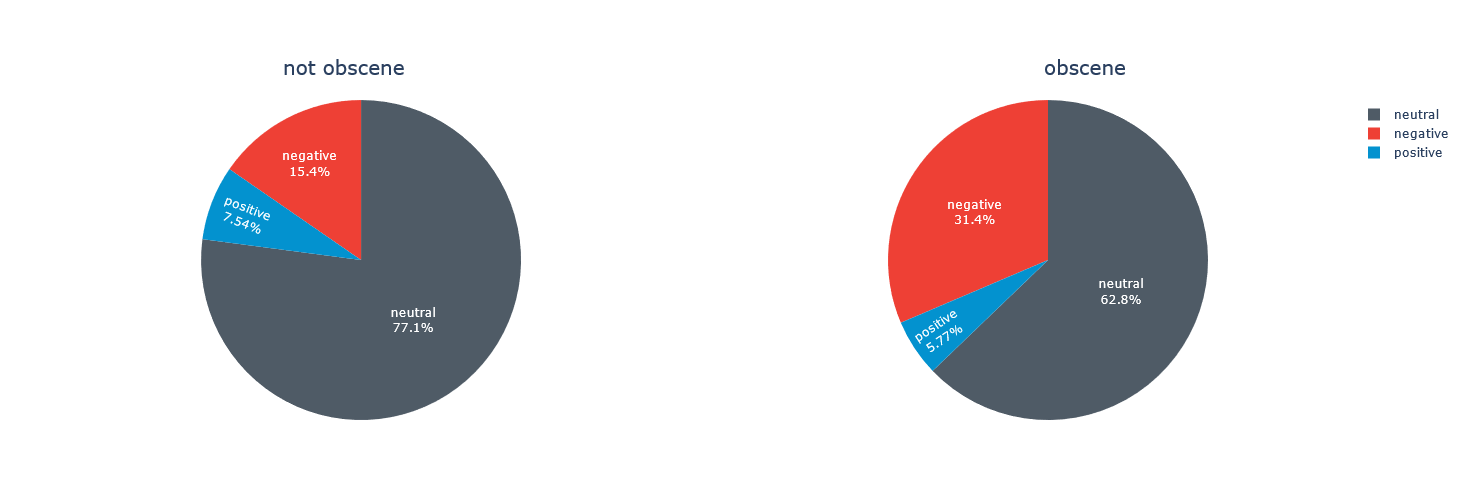

In [391]:
colors = ["#ee4035", "#4f5b66", "#0392cf"]

col1 = (
    df_flat.loc[df_flat["toxicity_ensemble_text.obscene"] == False][
        "sentiment_title.sentiment.class"
    ]
    .value_counts()
    .sort_index()
)
labels1 = col1.index.tolist()
values1 = col1.values.tolist()
col2 = (
    df_flat.loc[df_flat["toxicity_ensemble_text.obscene"] == True][
        "sentiment_title.sentiment.class"
    ]
    .value_counts()
    .sort_index()
)
labels2 = col2.index.tolist()
values2 = col2.values.tolist()


fig = make_subplots(rows=1, cols=2, specs=[[{"type": "domain"}, {"type": "domain"}]])
_ = fig.add_trace(
    go.Pie(
        labels=labels1,
        values=values1,
        name="not obscene",
        textinfo="label+percent",
        marker_colors=colors,
    ),
    1,
    1,
)
_ = fig.add_trace(
    go.Pie(
        labels=labels2,
        values=values2,
        name="obscene",
        textinfo="label+percent",
        marker_colors=colors,
    ),
    1,
    2,
)

_ = fig.update_layout(
    annotations=[
        dict(text="not obscene", x=0.16, y=1.15, font_size=20, showarrow=False),
        dict(text="obscene", x=0.84, y=1.15, font_size=20, showarrow=False),
    ],
    width=1000,
    height=500,
)
fig.show()

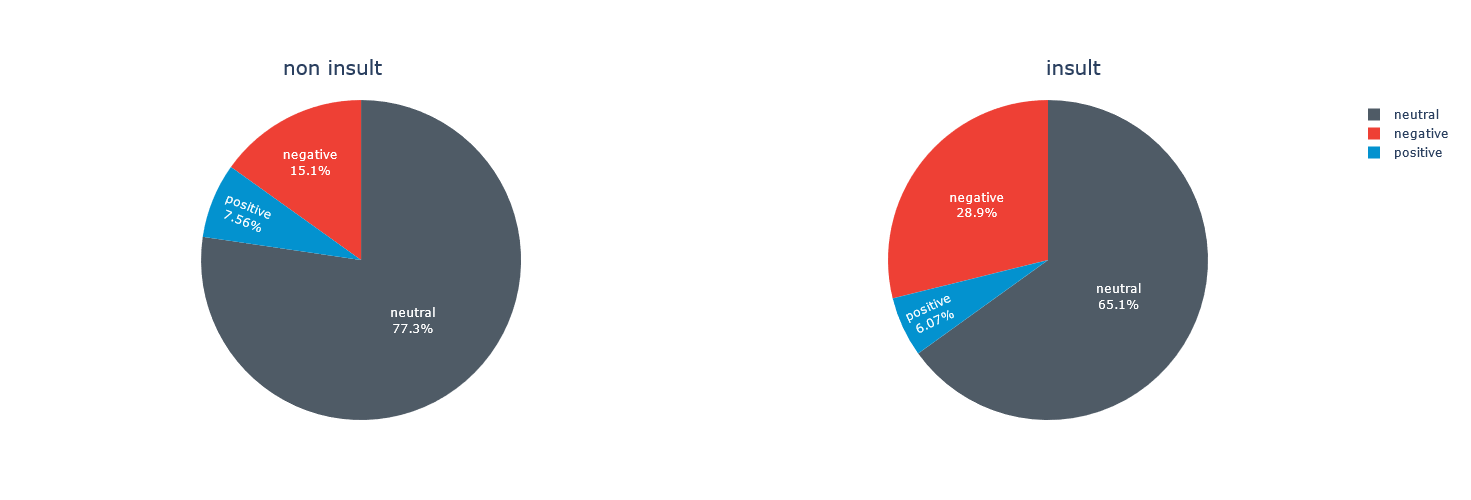

In [392]:
colors = ["#ee4035", "#4f5b66", "#0392cf"]

col1 = (
    df_flat.loc[df_flat["toxicity_ensemble_text.insult"] == False][
        "sentiment_title.sentiment.class"
    ]
    .value_counts()
    .sort_index()
)
labels1 = col1.index.tolist()
values1 = col1.values.tolist()
col2 = (
    df_flat.loc[df_flat["toxicity_ensemble_text.insult"] == True][
        "sentiment_title.sentiment.class"
    ]
    .value_counts()
    .sort_index()
)
labels2 = col2.index.tolist()
values2 = col2.values.tolist()


fig = make_subplots(rows=1, cols=2, specs=[[{"type": "domain"}, {"type": "domain"}]])
_ = fig.add_trace(
    go.Pie(
        labels=labels1,
        values=values1,
        name="non insult",
        textinfo="label+percent",
        marker_colors=colors,
    ),
    1,
    1,
)
_ = fig.add_trace(
    go.Pie(
        labels=labels2,
        values=values2,
        name="insult",
        textinfo="label+percent",
        marker_colors=colors,
    ),
    1,
    2,
)

_ = fig.update_layout(
    annotations=[
        dict(text="non insult", x=0.16, y=1.15, font_size=20, showarrow=False),
        dict(text="insult", x=0.82, y=1.15, font_size=20, showarrow=False),
    ],
    width=1000,
    height=500,
)
fig.show()

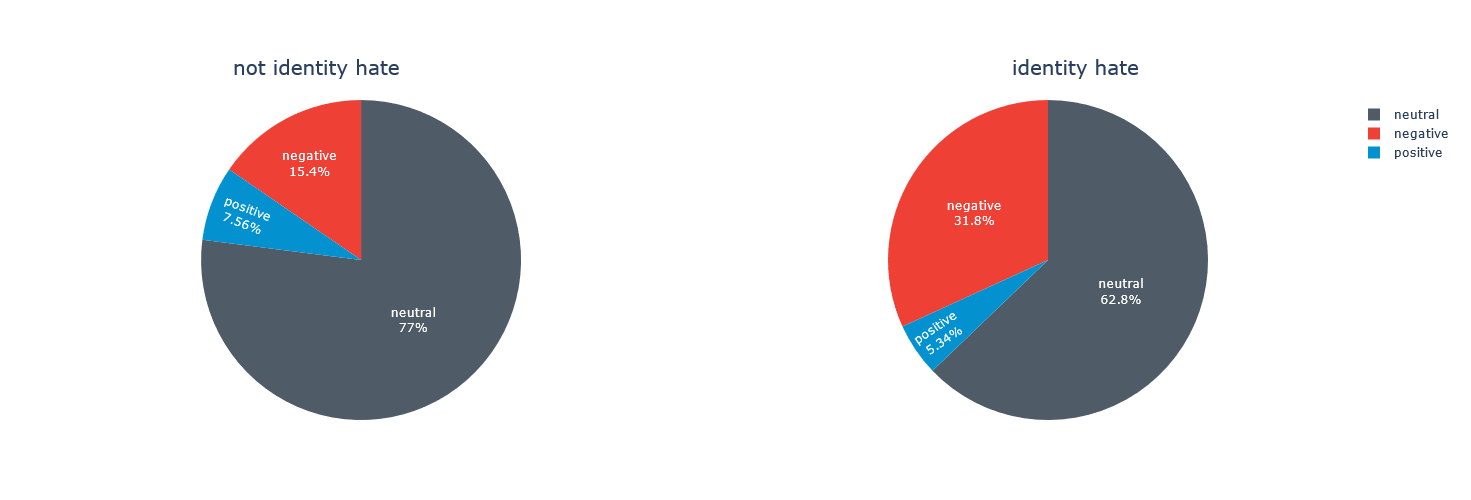

In [393]:
colors = ["#ee4035", "#4f5b66", "#0392cf"]

col1 = (
    df_flat.loc[df_flat["toxicity_ensemble_text.identity_hate"] == False][
        "sentiment_title.sentiment.class"
    ]
    .value_counts()
    .sort_index()
)
labels1 = col1.index.tolist()
values1 = col1.values.tolist()
col2 = (
    df_flat.loc[df_flat["toxicity_ensemble_text.identity_hate"] == True][
        "sentiment_title.sentiment.class"
    ]
    .value_counts()
    .sort_index()
)
labels2 = col2.index.tolist()
values2 = col2.values.tolist()


fig = make_subplots(rows=1, cols=2, specs=[[{"type": "domain"}, {"type": "domain"}]])
_ = fig.add_trace(
    go.Pie(
        labels=labels1,
        values=values1,
        name="not identity hate",
        textinfo="label+percent",
        marker_colors=colors,
    ),
    1,
    1,
)
_ = fig.add_trace(
    go.Pie(
        labels=labels2,
        values=values2,
        name="identity_hate",
        textinfo="label+percent",
        marker_colors=colors,
    ),
    1,
    2,
)

_ = fig.update_layout(
    annotations=[
        dict(text="not identity hate", x=0.12, y=1.15, font_size=20, showarrow=False),
        dict(text="identity hate", x=0.85, y=1.15, font_size=20, showarrow=False),
    ],
    width=1000,
    height=500,
)
fig.show()